<a href="https://colab.research.google.com/github/farshokat/my-project/blob/master/CTC_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import cv2

In [2]:
!unzip -qq plate_car.zip
!unzip -qq test_plate_car.zip

replace plate_car/12C02540.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test_plate_car/92A05660.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Path to the data directory
data_dir = Path("./plate_car/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

print(images[1])

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  284
Number of labels found:  284
Number of unique characters:  17
Characters present:  {'0', '1', 'D', '4', '3', 'G', '6', '8', 'E', '7', 'A', 'C', 'H', '5', 'B', '2', '9'}
plate_car/15C08740.jpg


In [3]:
test_path = Path("./test_plate_car")

In [4]:
images_test = sorted(list(map(str, list(test_path.glob("*.jpg")))))
labels_test = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images_test]

In [5]:

# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)
#print(char_to_num)
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

'''def split_data(images, labels, train_size=0.7, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    #print(size)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    #print(indices)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid
print(len(images))

# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))
#print(x_train)
print(len(x_valid))
#print(y_train)
print(len(y_valid))'''

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((images_test, labels_test))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

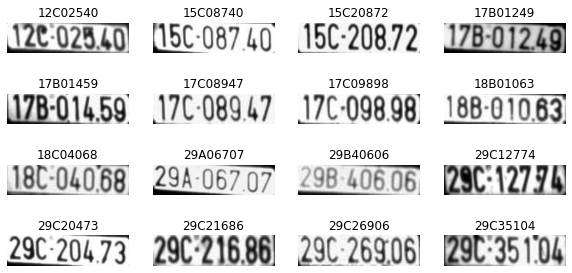

In [7]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    #print(len(images))
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [8]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [9]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    #validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
18/18 [==============================] - 12s 304ms/step - loss: 55.8240
Epoch 2/100
18/18 [==============================] - 6s 301ms/step - loss: 22.8714
Epoch 3/100
18/18 [==============================] - 6s 305ms/step - loss: 22.2697
Epoch 4/100
18/18 [==============================] - 5s 303ms/step - loss: 22.0752
Epoch 5/100
18/18 [==============================] - 6s 307ms/step - loss: 21.9961
Epoch 6/100
18/18 [==============================] - 5s 304ms/step - loss: 21.9374
Epoch 7/100
18/18 [==============================] - 6s 304ms/step - loss: 21.8589
Epoch 8/100
18/18 [==============================] - 5s 303ms/step - loss: 21.8140
Epoch 9/100
18/18 [==============================] - 6s 305ms/step - loss: 21.7162
Epoch 10/100
18/18 [==============================] - 6s 300ms/step - loss: 21.6332
Epoch 11/100
18/18 [==============================] - 6s 304ms/step - loss: 21.5496
Epoch 12/100
18/18 [==============================] - 6s 304ms/step - loss: 21.4150


In [10]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text
    #print(output_text)
    print(results)
#  Let's check results on some validation samples
"""for batch in validation_dataset.take(2):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    print(orig_texts)
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()
print(len(pred_texts))"""

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            49216 

'for batch in validation_dataset.take(2):\n    batch_images = batch["image"]\n    batch_labels = batch["label"]\n\n    preds = prediction_model.predict(batch_images)\n    pred_texts = decode_batch_predictions(preds)\n\n    orig_texts = []\n    for label in batch_labels:\n        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")\n        orig_texts.append(label)\n    print(orig_texts)\n    _, ax = plt.subplots(4, 4, figsize=(15, 5))\n    for i in range(len(pred_texts)):\n        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)\n        img = img.T\n        title = f"Prediction: {pred_texts[i]}"\n        ax[i // 4, i % 4].imshow(img, cmap="gray")\n        ax[i // 4, i % 4].set_title(title)\n        ax[i // 4, i % 4].axis("off")\nplt.show()\nprint(len(pred_texts))'

In [12]:
preds = prediction_model.predict(validation_dataset)
#pred_texts = decode_batch_predictions(preds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [13]:
pred_texts = decode_batch_predictions(preds)

In [14]:
print(pred_texts)

['73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UNK][UNK][UNK][UNK][UNK]', '73C[UN

In [11]:
for batch in train_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

In [12]:
print(pred_texts)

['12C02540', '15C08740', '15C20872', '17B01249', '17B01459', '17C08947', '17C09898', '18B01063', '18C04068', '29A06707', '29B40606', '29C12774', '29C20473', '29C21686', '29C26906', '29C35104']


In [13]:
for batch_test in validation_dataset.take(1):
    batch_images_test = batch_test["image"]
    batch_labels_test = batch_test["label"]

    preds_test = prediction_model.predict(batch_images_test)
    pred_texts_test = decode_batch_predictions(preds_test)

In [14]:
print(pred_texts_test)

['92A05660', '92A05905', '92A06021', '92A06169', '92A06431', '92A07934', '92A08173', '92A09176', '92A09375', '92A09408', '92A09491', '92A09648', '92A09721', '92A09882', '92A10486', '92A10631']


['92A05660', '92A05905', '92A06021', '92A06189', '92A06437', '92A07934', '92A08173', '92A09176', '92A09375', '92A09408', '92A09491', '92A09648', '92A09721', '92A09882', '92A10486', '92A10631']
['92A10801', '92B00400', '92B00897', '92B01201', '92C01099', '92C02103', '92C02329', '92C02464', '92C03930', '92C04019', '92C04510', '92C04749', '92C04963', '92C05045', '92C05262', '92C05437']
['92C05979', '92C06067', '92C06272', '92C06616', '92C06827', '92C07464', '92C07473', '92C08343', '92C08530', '92C08723', '92C08786', '92C09229', '92C09532', '92C09618', '92C09646', '92C10160']
['92C10300', '92C10361', '92C10612', '92C10720', '92C11106', '92C11235', '92C11258', '92C11285', '92C11460', '92C11783', '92C12191', '92C12684', '98C07170', '98C07407', '98C09800', '98C10268']


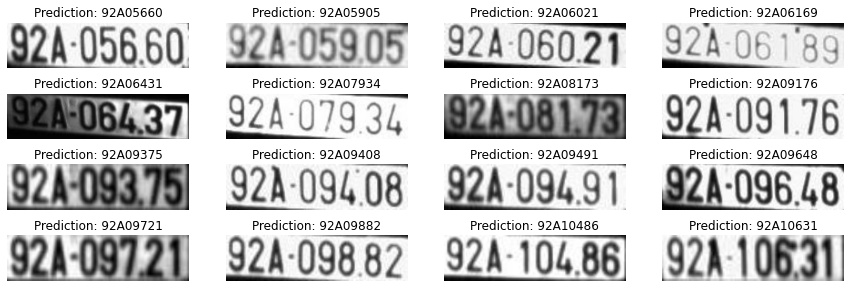

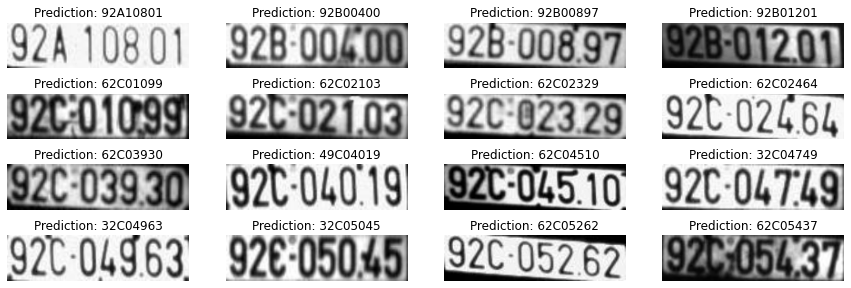

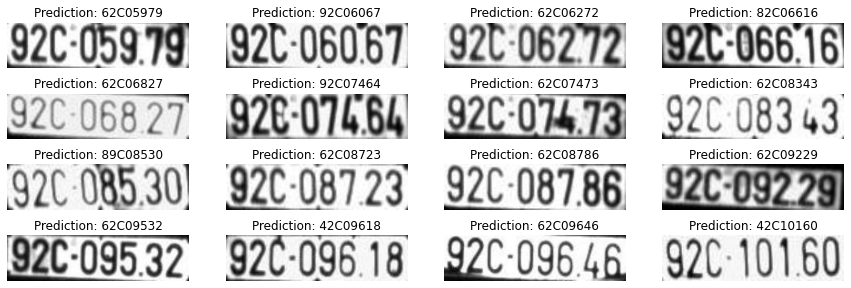

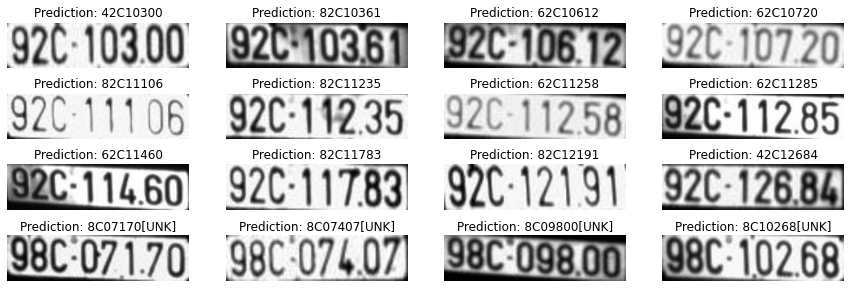

16


In [19]:
for batch in validation_dataset.take(6):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    print(orig_texts)
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()
print(len(pred_texts))